# Discrete Cosine Transform (DCT)

The DCT transforms a discrete signal into a linear combination of cosine functions of varying frequencies.

This notebook intends to provide a visual explanation of the cosine basis functions in one and two dimensions.

**References**:
* Syed Ali Khayam. The Discrete Cosine Transform (DCT): Theory and Application. http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.184.6102
* Pennebaker, William B. and Mitchell, Joan L. JPEG Still Image Data Compression Standard. New York: Van Nostrand Reinhold, 1992. 

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dct as scipy_dct
from IPython.core.display import display, HTML


display(HTML("<style>.container { width:70% !important; }</style>"))


plt.style.use("seaborn-darkgrid")

## One-Dimensional DCT

The most common DCT definition of a 1-D sequence of length `N` is

$$F(i) = \alpha(i) \sum\limits_{x=0}^{N-1} f(x) \cos\left(\frac{\pi (2x + 1) i}{2N}\right)$$

for `i = 0, 1, 2, ..., N - 1` with

$$\alpha(i) = \begin{cases}\sqrt{\frac{1}{N}} & i = 0\\ \sqrt{\frac{2}{N}} & i \neq 0\end{cases}$$

Similarly, the inverse transformation is defined as

$$f(x) = \sum\limits_{i=0}^{N-1} \alpha(u) F(i) \cos\left(\frac{\pi (2x + 1) i}{2N}\right)$$

### Basis functions
The cosine basis functions are orthogonal. Therefore, the scalar product of a waveform with any other waveform is zero.

In [2]:
def dct_1d_basis_functions(N):
    base_funcs = np.zeros((N, N))
    
    for i in range(N):
        alpha = np.sqrt(1/N) if i == 0 else np.sqrt(2/N)
        for x in range(N):
            base_funcs[i, x] = alpha * np.cos((np.pi * (2 * x + 1) * i) / (2 * N))
            
    return base_funcs

Visualize basis functions.

<IPython.core.display.Javascript object>


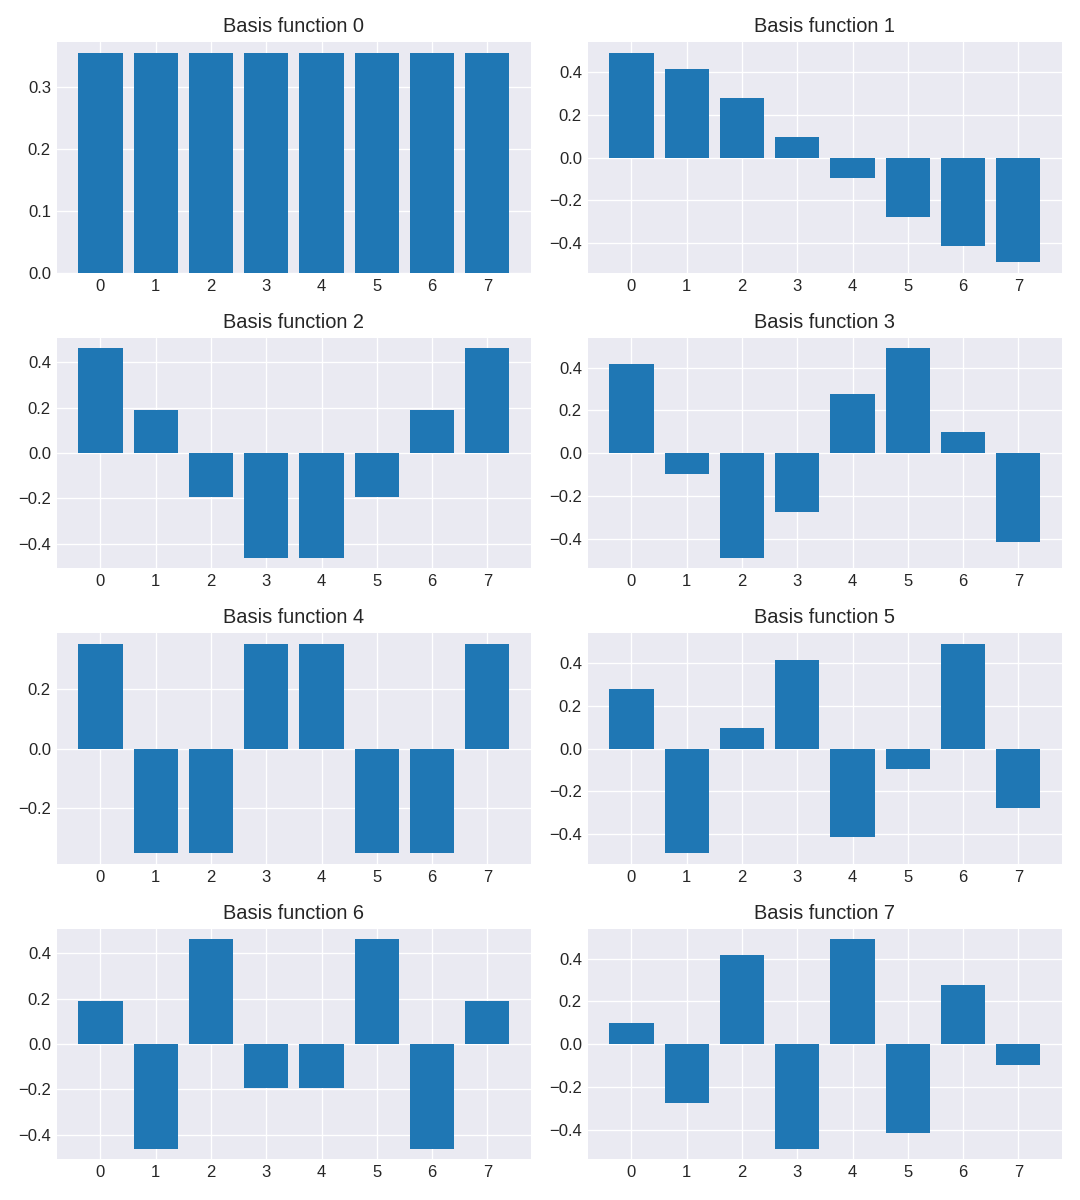

In [3]:
xs = np.arange(8)
waveforms = dct_1d_basis_functions(8)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(9, 10))
for i in range(8):
    row = i // 2
    col = i % 2
    axes[row, col].bar(xs, waveforms[i])
    axes[row, col].set_title("Basis function {:d}".format(i))

fig.tight_layout()
fig.show()

### Naive 1-D DCT implementation

In [4]:
def dct_1d(signal):
    N = len(signal)
    F = np.zeros(N)
    
    for i in range(N):
        for x in range(N):
            F[i] += signal[x] * np.cos((np.pi * (2 * x + 1) * i) / (2 * N))

        alpha = np.sqrt(1/N) if i == 0 else np.sqrt(2/N)
        F[i] *= alpha
    
    return F


def idct_1d(F):
    N = len(F)
    f = np.zeros(N)
    
    for x in range(N):
        for i in range(N):
            alpha = np.sqrt(1/N) if i == 0 else np.sqrt(2/N)
            f[x] += alpha * F[i] * np.cos((np.pi * (2 * x + 1) * i) / (2 * N))
    
    return f

Ensure that `idct_1d(dct_1d(signal)) == signal`.

In [6]:
# Generate random signal
x = np.random.randn(20)
# Transform from spatial to DCT domain
x_dct = dct_1d(x)
# Transform back into spatial domain
x_recovered = idct_1d(x_dct)

print("1-D DCT reconstruction: {}".format(np.allclose(x, x_recovered)))

1-D DCT reconstruction: True


### Progressive summing

Given the DCT coefficients of a signal, we can progressively sum the waveforms corresponding to the coefficients. We start with the lowest frequency, and add one more waveform each time, until the original sample is finally reconstructed.

<IPython.core.display.Javascript object>


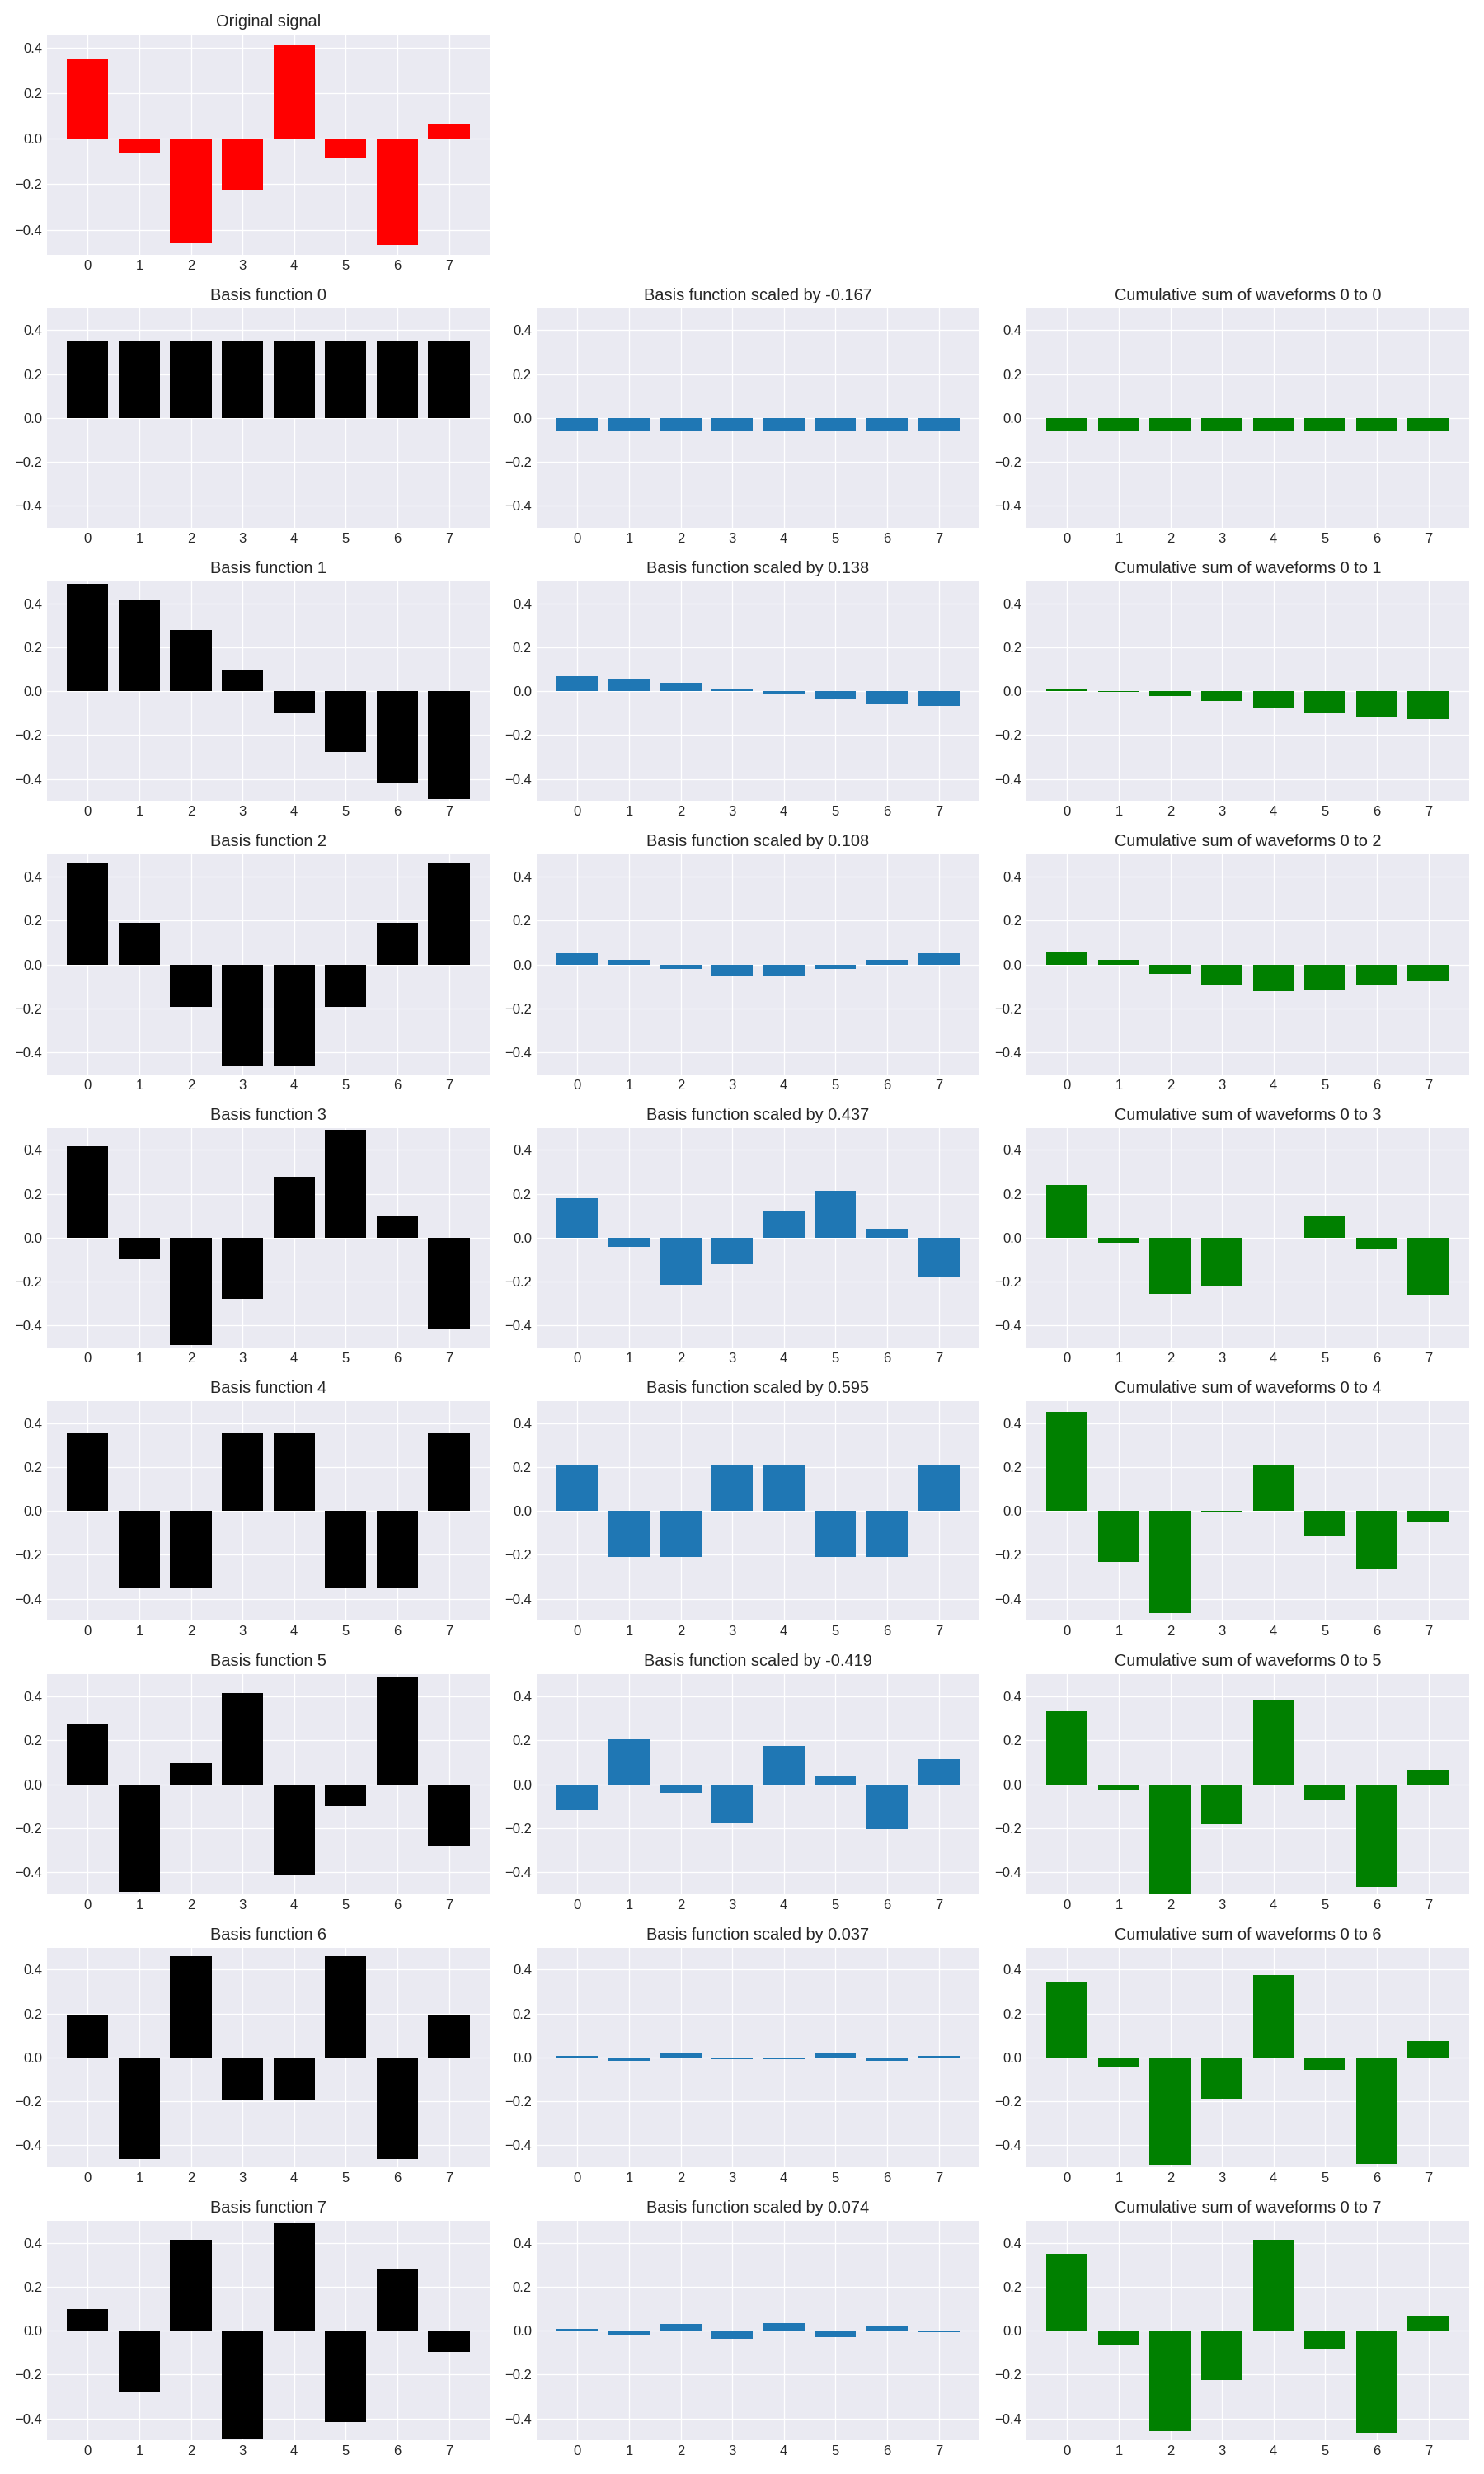

In [7]:
np.random.seed(91058)
x = np.random.randn(8) * 0.5
x_dct = dct_1d(x)
basis_functions = dct_1d_basis_functions(len(x))

xs = np.arange(len(x))
fig, axes = plt.subplots(9, 3, figsize=(15, 25))
axes[0, 0].bar(xs, x, color="r")
axes[0, 0].set_title("Original signal")

axes[0, 1].set_axis_off()
axes[0, 2].set_axis_off()

y_min = x.min()
y_max = x.max()

for i in range(8):
    row = i + 1
    axes[row, 0].bar(xs, basis_functions[i], color="k")
    axes[row, 0].set_title("Basis function {}".format(i))
    axes[row, 0].set_ylim([-0.5, 0.5])
    
    axes[row, 1].bar(xs, basis_functions[i] * x_dct[i])
    axes[row, 1].set_title("Basis function scaled by {:4.3f}".format(x_dct[i]))
    axes[row, 1].set_ylim([-0.5, 0.5])
    
    x_dct_subset = np.dot(basis_functions[:(i+1)].T, x_dct[:(i+1), None])
    axes[row, 2].bar(xs, x_dct_subset.ravel(), color="g")
    axes[row, 2].set_title("Cumulative sum of waveforms 0 to {}".format(i))
    axes[row, 2].set_ylim([-0.5, 0.5])

    
fig.tight_layout()

## Two-Dimensional DCT

$$F(i, j) = \alpha(i) \alpha(j) \sum\limits_{x=0}^{N-1} \sum\limits_{y=0}^{N-1} f(x, y) \cos\left(\frac{\pi (2x + 1) i}{2N}\right) \cos\left(\frac{\pi (2y + 1) j}{2N}\right)$$

for `i, j = 0, 1, 2, ..., N - 1`.

The inverse transform is defined as

$$f(x, y) = \sum\limits_{i=0}^{N-1} \sum\limits_{j=0}^{N-1} \alpha(i) \alpha(j) F(i, j) \cos\left(\frac{\pi(2x + 1)i}{2N}\right) \cos\left(\frac{\pi (2y + 1) j}{2N}\right)$$

for `x, y = 0, 1, 2, ..., N - 1`.

### Naive 2-D DCT implementation

In [8]:
def dct_2d(signal):
    N = signal.shape[0]
    
    F = np.zeros((N, N))
    for j in range(N):
        for i in range(N):
            
            for y in range(N):
                for x in range(N):
                    F[j, i] += signal[y, x] * np.cos((np.pi * (2 * x + 1) * i) / (2 * N)) * np.cos((np.pi * (2 * y + 1) * j) / (2 * N))
            
            alpha_i = np.sqrt(1/N) if i == 0 else np.sqrt(2/N)
            alpha_j = np.sqrt(1/N) if j == 0 else np.sqrt(2/N)
            F[j, i] *= alpha_i * alpha_j
    
    return F


def idct_2d(F):
    N = F.shape[0]
    
    f = np.zeros((N, N))
    for y in range(N):
        for x in range(N):
            
            for j in range(N):
                for i in range(N):
                    alpha_i = np.sqrt(1/N) if i == 0 else np.sqrt(2/N)
                    alpha_j = np.sqrt(1/N) if j == 0 else np.sqrt(2/N)
                    f[y, x] += alpha_i * alpha_j * F[j, i] * np.cos((np.pi * (2 * x + 1) * i)/(2 * N)) * np.cos((np.pi * (2 * y + 1) * j) / (2 * N))
                    
    return f

Ensure that `idct_2d(dct_2d(signal)) == signal` and compare against *scipy*'s DCT.

In [9]:
x = np.random.randn(8, 8)
x_dct = dct_2d(x)
x_recovered = idct_2d(x_dct)
print("2-D DCT reconstruction: {}".format(np.allclose(x, x_recovered)))
print("2-D DCT forward transform equivalent with scipy: {}".format(np.allclose(dct_2d(x), scipy_dct(scipy_dct(x.T, norm='ortho').T, norm='ortho'))))

2-D DCT reconstruction: True
2-D DCT forward transform equivalent with scipy: True


### Basis functions

In [10]:
def dct_2d_basis_functions(N):
    base_funcs = np.zeros((N, N, N, N))
    
    for j in range(N):
        for i in range(N):
            alpha_i = np.sqrt(1/N) if i == 0 else np.sqrt(2/N)
            alpha_j = np.sqrt(1/N) if j == 0 else np.sqrt(2/N)
            
            for y in range(N):
                for x in range(N):
                    base_funcs[j, i, y, x] = alpha_i * alpha_j * np.cos((np.pi * (2 * x + 1) * i)/(2 * N)) * np.cos((np.pi * (2 * y + 1) * j) / (2 * N))
                    
    return base_funcs

Visualize basis functions.

<IPython.core.display.Javascript object>


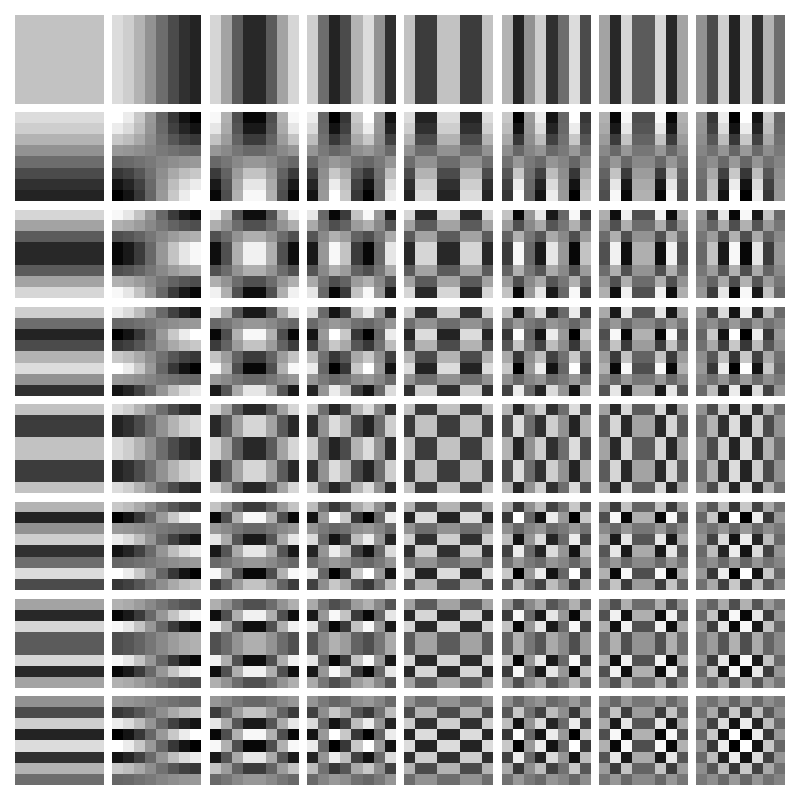

In [11]:
waveforms_2d = dct_2d_basis_functions(8)

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))
for j in range(8):
    for i in range(8):
        axes[j, i].imshow(waveforms_2d[j, i], vmin=waveforms_2d.min(), vmax=waveforms_2d.max(), cmap='gray')
        axes[j, i].axis('off')
        
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.show()